# Train a Regression ConvNN Model Using BOHB Tuned Hyperparameters

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from DeepRegTrainer import *
from DeepRegBuilder import *
from StatVisAnalyzer import regression_report

Loading BokehJS ...

# Step 1: Load the training dataset (syntheric spectra)

In [2]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [3]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [4]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [5]:
training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [6]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


## Prepare feature variables (X) and targets (y)

In [7]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

/var/folders/30/n2yd25m90v1bywy0rcgx4fqc0000gq/T/ipykernel_47448/1983952283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, 'temperature'] = np.log10(y['temperature'])


In [9]:
y.head(5)

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Build the CNN model / Data processing

In [10]:
# Instintiate TrainCNNRegression class
train_cnn_regression = TrainRegression(feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

#### Split the dataset into train, validate and test sets

In [11]:
train_cnn_regression.split_train_validation_test(test_size=0.1, 
                                                 val_size=0.1, 
                                                 random_state_=42,)

In [12]:
# Scale the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

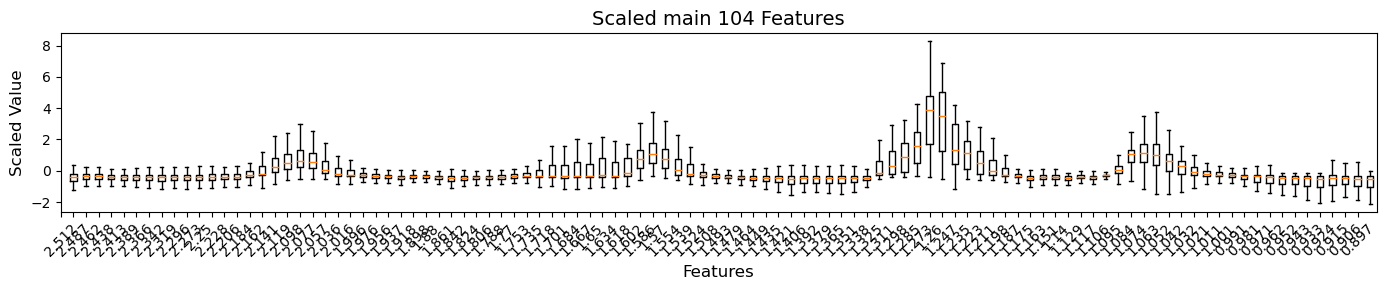

In [13]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### Scale y features - ColumnWise

In [14]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

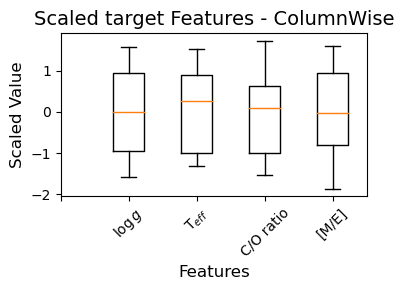

In [15]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [16]:
# train_cnn_regression.y_train_standardized_columnwise

### Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
# train
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

# validation
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

# test
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [18]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [19]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [20]:
df_MinMax_train.head()

,min,max
0,8.265340e-12,3.445259e-08
1,8.080712e-22,8.397132e-14
2,2.734403e-07,8.632182e-06
3,4.414951e-16,3.373262e-10
4,3.722576e-07,6.859888e-06


---

### Scale Min Max features - ColumnWise

In [21]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

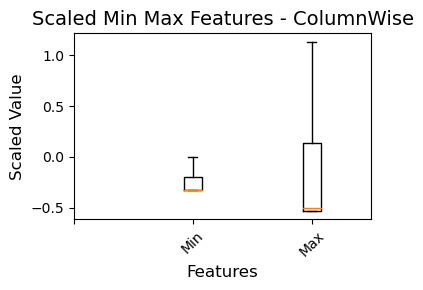

In [22]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Train CNN model

In [23]:
train_cnn_model = TrainCNN(
            # input dataset: StandardScaled instances  
            X1_train = train_cnn_regression.X_train_standardized_rowwise,
            X1_val   = train_cnn_regression.X_val_standardized_rowwise,
            X1_test  = train_cnn_regression.X_test_standardized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = train_cnn_regression.X_train_standardized_columnwise,
            X2_val   = train_cnn_regression.X_val_standardized_columnwise,
            X2_test  = train_cnn_regression.X_test_standardized_columnwise,

            # 1st target
            y1_train = train_cnn_regression.y_train_standardized_columnwise[:,0],
            y1_val   = train_cnn_regression.y_val_standardized_columnwise[:,0],
            y1_test  = train_cnn_regression.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = train_cnn_regression.y_train_standardized_columnwise[:,1],
            y2_val   = train_cnn_regression.y_val_standardized_columnwise[:,1],
            y2_test  = train_cnn_regression.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = train_cnn_regression.y_train_standardized_columnwise[:,2],
            y3_val   = train_cnn_regression.y_val_standardized_columnwise[:,2],
            y3_test  = train_cnn_regression.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = train_cnn_regression.y_train_standardized_columnwise[:,3],
            y4_val   = train_cnn_regression.y_val_standardized_columnwise[:,3],
            y4_test  = train_cnn_regression.y_test_standardized_columnwise[:,3],
            )

In [24]:
hyperparameters = {
    'Conv__num_blocks': 2,
    'Conv__num_layers_per_block': 3,
    'Conv__num_filters': 8,
    'Conv__kernel_size': 3,
    'Conv__MaxPooling1D': 2,
    'FC1__num_blocks': 1,
    'FC1_num_layers_per_block': 3,
    'FC1__units': 128,
    'FC1__dropout': 0.2,
    'FC2__num_blocks': 1,
    'FC2_num_layers_per_block': 2,
    'FC2__units': 128,
    'FC2__dropout': 0.2,
    'learning_rate' : 0.0001
}



In [25]:
train_cnn_model.build_model(hyperparameters = hyperparameters, 
                     )

2023-08-01 09:51:45.697094: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
Conv__B1_L1 (Conv1D)            (None, 104, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
Conv__B1_L2 (Conv1D)            (None, 104, 128)     12416       Conv__B1_L1[0][0]                
__________________________________________________________________________________________________
Conv__B1_L3 (Conv1D)            (None, 104, 288)     110880      Conv__B1_L2[0][0]                
______________________________________________________________________________________________

In [ ]:
history, model =  train_cnn_model.fit_cnn_model(budget=30)

2023-08-01 09:51:56.572246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
782/782 [==============================] - 105s 133ms/step - loss: 0.2831 - gravity_loss: 0.1072 - c_o_ratio_loss: 0.0625 - metallicity_loss: 0.0992 - temperature_loss: 0.0142 - gravity_mae: 0.3393 - c_o_ratio_mae: 0.2559 - metallicity_mae: 0.3451 - temperature_mae: 0.1220 - val_loss: 0.1048 - val_gravity_loss: 0.0217 - val_c_o_ratio_loss: 0.0217 - val_metallicity_loss: 0.0580 - val_temperature_loss: 0.0034 - val_gravity_mae: 0.1570 - val_c_o_ratio_mae: 0.1608 - val_metallicity_mae: 0.2651 - val_temperature_mae: 0.0643
Epoch 2/30
782/782 [==============================] - 132s 169ms/step - loss: 0.1017 - gravity_loss: 0.0236 - c_o_ratio_loss: 0.0194 - metallicity_loss: 0.0532 - temperature_loss: 0.0055 - gravity_mae: 0.1650 - c_o_ratio_mae: 0.1545 - metallicity_mae: 0.2557 - temperature_mae: 0.0812 - val_loss: 0.0893 - val_gravity_loss: 0.0175 - val_c_o_ratio_loss: 0.0122 - val_metallicity_loss: 0.0566 - val_temperature_loss: 0.0029 - val_gravity_mae: 0.1453 - val_c_o_ratio_

In [35]:
train_cnn_regression.trained_model = model
train_cnn_regression.history = history

In [30]:
model

In [32]:
history.history

{'loss': [0.28880834579467773, 0.10734215378761292],
 'FC3__gravity_loss': [0.10936300456523895, 0.026016443967819214],
 'FC3__c_o_ratio_loss': [0.06366211175918579, 0.020274722948670387],
 'FC3__metallicity_loss': [0.10088668763637543, 0.05526529252529144],
 'FC3__temperature_loss': [0.01489646639674902, 0.005785715766251087],
 'FC3__gravity_mae': [0.34448960423469543, 0.17236332595348358],
 'FC3__c_o_ratio_mae': [0.2608736753463745, 0.15750449895858765],
 'FC3__metallicity_mae': [0.3501751124858856, 0.2595546245574951],
 'FC3__temperature_mae': [0.12667419016361237, 0.0838003158569336],
 'val_loss': [0.12417980283498764, 0.08126870542764664],
 'val_FC3__gravity_loss': [0.03960089758038521, 0.01361505500972271],
 'val_FC3__c_o_ratio_loss': [0.019983315840363503, 0.015651486814022064],
 'val_FC3__metallicity_loss': [0.05754002183675766, 0.04786324128508568],
 'val_FC3__temperature_loss': [0.007055582944303751, 0.004138931632041931],
 'val_FC3__gravity_mae': [0.21832410991191864, 0.1182

In [33]:
tf.keras.utils.plot_model(
                train_cnn_model.model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Save Trained Model

In [36]:
train_cnn_regression.trained_model.save('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__newbuild_v1.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_v1.h5')

with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_v1.pkl', 'wb') as file:
    pk.dump(train_cnn_regression.history.history, file)
    


## Load Saved Models

In [37]:
model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__newbuild_v1.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_v1.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_v1.pkl', 'rb') as file:
    history = pk.load(file)    

In [38]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

In [43]:
train_cnn_regression.trained_model_history[]

{'loss': [0.28880834579467773, 0.10734215378761292],
 'FC3__gravity_loss': [0.10936300456523895, 0.026016443967819214],
 'FC3__c_o_ratio_loss': [0.06366211175918579, 0.020274722948670387],
 'FC3__metallicity_loss': [0.10088668763637543, 0.05526529252529144],
 'FC3__temperature_loss': [0.01489646639674902, 0.005785715766251087],
 'FC3__gravity_mae': [0.34448960423469543, 0.17236332595348358],
 'FC3__c_o_ratio_mae': [0.2608736753463745, 0.15750449895858765],
 'FC3__metallicity_mae': [0.3501751124858856, 0.2595546245574951],
 'FC3__temperature_mae': [0.12667419016361237, 0.0838003158569336],
 'val_loss': [0.12417980283498764, 0.08126870542764664],
 'val_FC3__gravity_loss': [0.03960089758038521, 0.01361505500972271],
 'val_FC3__c_o_ratio_loss': [0.019983315840363503, 0.015651486814022064],
 'val_FC3__metallicity_loss': [0.05754002183675766, 0.04786324128508568],
 'val_FC3__temperature_loss': [0.007055582944303751, 0.004138931632041931],
 'val_FC3__gravity_mae': [0.21832410991191864, 0.1182

# Step 4: Check Trained Model

---

In [40]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [41]:
train_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
Conv__B1_L1 (Conv1D)            (None, 104, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
Conv__B1_L2 (Conv1D)            (None, 104, 128)     12416       Conv__B1_L1[0][0]                
__________________________________________________________________________________________________
Conv__B1_L3 (Conv1D)            (None, 104, 288)     110880      Conv__B1_L2[0][0]                
______________________________________________________________________________________________

In [42]:
train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

KeyError: 'gravity_loss'

### Plot Y predicted vs Y_Actual: Histogram & Scatter plot

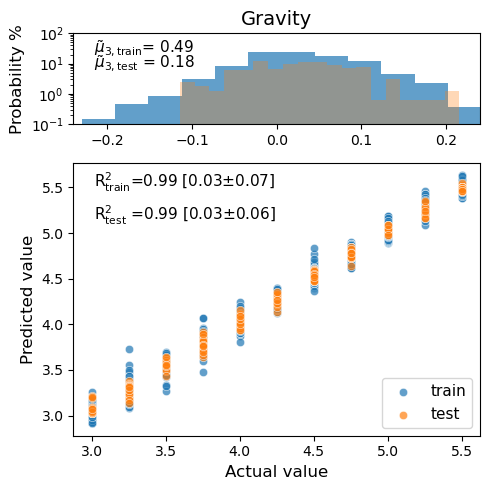

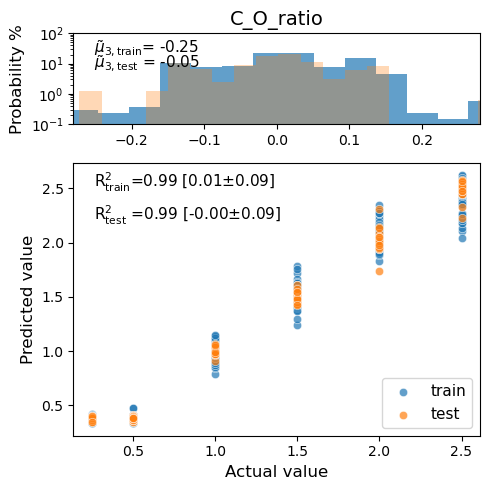

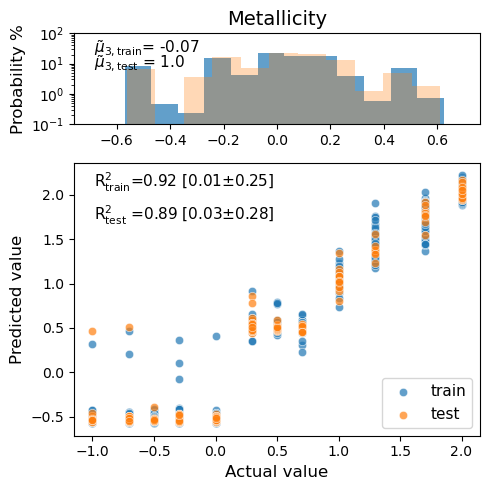

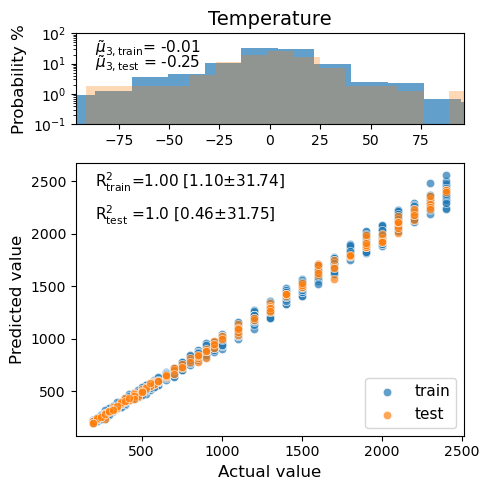

In [277]:
i = 19
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )